<a href="https://colab.research.google.com/github/ThiagoSDomingues/Causality-analysis/blob/main/Duke_causality_constraints_one_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
!git clone https://github.com/Duke-QCD/trento.git
!cd trento && ls -l
!cd trento && mkdir build && cd build
!ls -l trento/build/ && cd trento/build/  && cmake .. && make install
!pip install freestream

import shutil
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import numpy as np
import h5py
import freestream
import scipy.linalg as la
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import math
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate


def EoS_data():

    hbarc=0.1973

# Reading EoS data
# Loading EOS from MUSIC (generated with https://github.com/j-f-paquet/eos_maker - SMASH branch )
# eos_location="./music/EOS/hotQCD/hrg_hotqcd_eos_binary.dat"
# eos_location="/home/jp401/Dropbox/work/my_papers/effective_visc_bjorken/results/bjorken_relax/music/EOS/hotQCD/hrg_hotqcd_eos_binary.dat"

#eos_location="./hrg_hotqcd_eos_binary.dat" # eos_data path
    eos_location = "/content/drive/MyDrive/hrg_hotqcd_eos_binary.dat" # 3.05 MB. The file is in my google drive

    raw=np.fromfile(eos_location, dtype=(float,4)) # lendo o dado bruto

# 4 columns (energy density, local pressure, entropy density, local temperature)

    e=raw[:,0] # GeV/fm^3
    p=raw[:,1] # GeV/fm^3
    s=raw[:,2] # fm^-3
    T=raw[:,3] # GeV

# We need to get 5 equilibrium variables.
#cs2=CubicSpline(e, p)(e, nu=1). Velocidade do som ao quadrado é uma derivada da pressão em relação a densidade de energia (zero chemical potential)
# We need to construct a linear ? spline (interpolation) 1-D between the pressure and energy density and to take the first-order derivative

    cs2=InterpolatedUnivariateSpline(e,p,k=1).derivative(n=1)(e)

#print(cs2)

# cs2_fct takes the temperature in fm^-1
    cs2_qcd_fct=InterpolatedUnivariateSpline(T/hbarc,cs2)

    return e, p, s, T, cs2
#hotQCD=np.loadtxt("hotQCD-EOS.dat")
#
#for line in hotQCD:
#    print(line[0],line[16],cs2_fct(line[0]/1000))

from google.colab import drive
drive.mount('/content/drive')

energy, pressure, entropy, temperature, sound = EoS_data()


# Create interpolation functions
eos_spline = interp.InterpolatedUnivariateSpline(energy, pressure)
p_interp = interpolate.interp1d(energy, pressure, kind='linear', bounds_error=False, fill_value=0)
s_interp = interpolate.interp1d(energy, entropy, kind='linear', bounds_error=False, fill_value=0)
T_interp = interpolate.interp1d(energy, temperature, kind='linear', bounds_error=False, fill_value=0)
cs2_interp = interpolate.interp1d(energy, sound, kind='linear', bounds_error=False, fill_value=0)
e_interp = interpolate.interp1d(temperature, energy, kind='linear', bounds_error=False, fill_value=0)
# Calculate pressure, entropy, and temperature for new energy density data

Cloning into 'trento'...
remote: Enumerating objects: 1138, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1138 (delta 65), reused 65 (delta 33), pack-reused 1039
Receiving objects: 100% (1138/1138), 485.19 KiB | 8.51 MiB/s, done.
Resolving deltas: 100% (818/818), done.
total 28
-rw-r--r-- 1 root root 5992 Feb  1 13:34 CMakeLists.txt
drwxr-xr-x 4 root root 4096 Feb  1 13:34 doc
-rw-r--r-- 1 root root 1120 Feb  1 13:34 LICENSE
-rw-r--r-- 1 root root  397 Feb  1 13:34 README.rst
drwxr-xr-x 2 root root 4096 Feb  1 13:34 src
drwxr-xr-x 3 root root 4096 Feb  1 13:34 test
total 0
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The CXX compiler identification is GNU 11

In [ ]:
### Necessary Conditions

def n_1(C_eta, R_bulk, lambda_1, e, p):

    condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
    return condition >= 0

def n_2(C_eta, R_bulk, lambda_3, e, p):

    condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
    return condition >= 0

def n_3(C_eta, R_bulk, lambda_3, e, p):

    condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
    return condition >= 0

def n_4(C_eta, R_bulk, lambda_a, lambda_d, e, p):

    condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
    return condition >= 0

def n_5(C_eta, C_zeta, cs_2, R_bulk, lambda_1, e, p):

    condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 + cs_2)*R_bulk + (38/21 + (8/5)*(1/3 - cs_2) + cs_2)*(lambda_1)/(e + p)
    return condition >= 0

def n_6(C_eta, C_zeta, cs_2, R_bulk, lambda_3, e, p):

    condition = 1 - (cs_2 + (4/3)*(1/C_eta) + 1/C_zeta) + (-7/15 - cs_2)*(R_bulk) + (-17/21 - (8/5)*(1/3 - cs_2) - cs_2)*(lambda_3)/(e + p)
    return condition >= 0

### Sufficient conditions



def s_1(C_eta, R_bulk, lambda_1, lambda_3, e, p):

    condition = 1/C_eta - np.abs(lambda_1)/(e+p) + (2/5)*(R_bulk) - (5/7)*(lambda_3/(e+p))
    return condition >= 0

def s_2(C_eta,  R_bulk, lambda_1, e, p):

    condition = 1/C_eta + (3/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e+p)
    return condition >= 0

# s_3 and s_4 are always satisfied !

def s_5(C_eta, C_zeta, cs2, R_bulk, lambda_1, lambda_3, e, p):

    condition = (1 + R_bulk)*(1 - cs2) - (4/(3*C_eta) + 1/C_zeta + (22/15)*R_bulk + (38/21 + (8/5)*(1/3 - cs2) + cs2)*(lambda_3)/(e+p) + np.abs(lambda_1)/(e+p) + (17/14)*((8/5)*(1/3 - cs2) + cs2 - 5/42)*((lambda_3/(e+p) + np.abs(lambda_1)/(e+p))**2)/(1-1/C_eta + (2/5)*R_bulk - np.abs(lambda_1)/(e+p) - (5/7)*lambda_3/(e+p)))
    return condition >= 0

def s_6(C_eta, C_zeta, cs2, R_bulk, lambda_1, e, p):

    condition = 1/(3*C_eta) + 1/C_zeta + cs2 + (13/15 + cs2)*(R_bulk) + (-23/21 + (8/5)*(1/3 - cs2) - cs2)*np.abs(lambda_1)/(e+p)
    return condition >= 0

def s_7(C_eta, cs2, R_bulk, lambda_1, lambda_3, e, p):

    condition = ( 1/C_eta + (3/5)*(R_bulk) - (5/7)*np.abs(lambda_1)/(e+p) )**2 - (17/14)*((8/5)*(1/3 - cs2) + cs2 - 5/42)*(lambda_3/(e+p) + np.abs(lambda_1)/(e+p))**2
    return condition >= 0

def s_8(C_eta, C_zeta, cs2, R_bulk, lambda_1, lambda_2, lambda_3, e, p):

    condition = (4/3)*(1/C_eta) + 1/C_zeta + cs2 + (22/15 + cs2)*R_bulk - (22/21 - (8/5)*(1/3 - cs2) + cs2)*np.abs(lambda_1)/(e+p) - (1 + R_bulk + lambda_2/(e+p))*(1 + R_bulk + lambda_3/(e+p))/(3*(1 + R_bulk - lambda_1/(e+p))**2)
    return condition >= 0

########
def C_zeta_func(b_Pi, cs2):

    result = (b_Pi)/((1/3 - cs2)**2)

    return result

def thermo_QCD(e_density):

    local_pressure = p_interp(e_density) # Gevfm^-3
    sound_velocity_squared = cs2_interp(e_density)

    return sound_velocity_squared, local_pressure

def pi_eigen(shear_tensor):

    g = np.array([[1, -1, -1]])

    lower_shear_tensor = np.einsum('...uv,...vw', shear_tensor, g) # we need to lower one index
    eigenvalues, eigenvectors = np.linalg.eig(lower_shear_tensor)
    eigenvalues.sort(axis=-1)

    lambda_1 = eigenvalues[:,:,0].real
    lambda_2 = eigenvalues[:,:,1].real
    lambda_3 = eigenvalues[:,:,2].real

    return lambda_1, lambda_2, lambda_3

def bulk_reynolds(bulk_pressure, energy_density, local_pressure):

    return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)

# **Large Systems**

* **Pb-Pb (5.04 TeV)**

In [ ]:
# grid config
# Trento options
# leave commented out for min-bias
# b-min =
# b-max =
x = 7.0  # cross-section in fm^2
n_ev = 1
seed = 1
p = 0.007 # Energy deposition parameter
w = 0.956 # Gaussian nucleon width [fm]
sigma_k = 0.918 # Std. dev. of nucleon multiplicity fluctuations
k = 1/sigma_k**2
d = 1.27 # Minimum inter-nucleon distance [fm]
n = 18.38 # Normalization factor [GeV] 5.02 TeV
# n = 13.94 2.76 TeV
# generating Trento events
!/root/.local/bin/trento Pb Pb {n_ev} -p {p} -k {k} -w {w} -d {d} -n {n} --random-seed {seed} -q -o Duke_PbPb.map

Setting the MAP pamaters from Table IV :https://arxiv.org/pdf/1808.02106.pdf

We need to investigate the causality conditions for Pb-Pb and p-Pb systems.

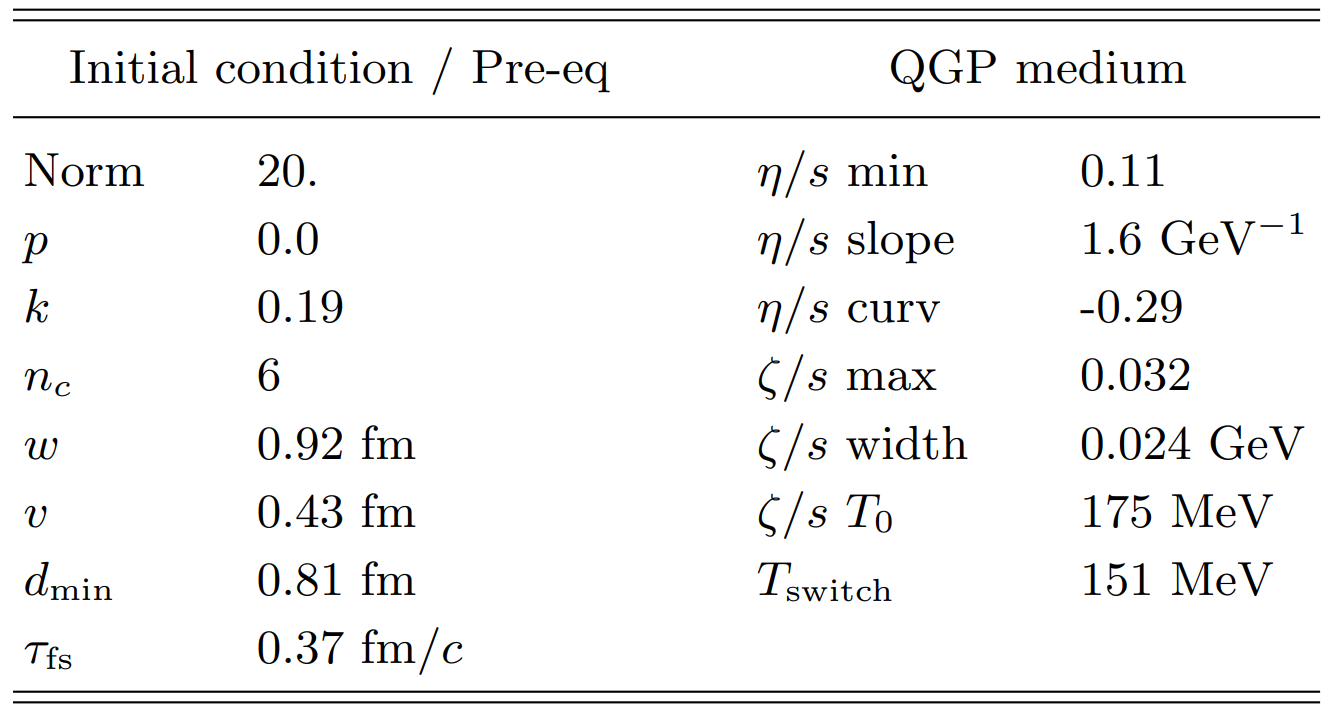

In [ ]:
# grid config
# Trento options
# leave commented out for min-bias
# b-min =
# b-max =
x = 7.0  # cross-section in fm^2 (5.04 TeV)
n_ev = 1
seed = 1

# Setting parameters
n = 20 # Normalization factor [GeV] 5.02 TeV
p = 0.0 # Energy deposition parameter
k = 0.19 # nucleon multiplicity fluctuation
n_c = 6 # Number of constituents inside the nucleon.
w = 0.92 # Gaussian nucleon width [fm]
v = 0.43 # Gaussian constituent width in [fm]
d = 0.81 # Minimum inter-nucleon distance [fm]

# generating Trento events
!/root/.local/bin/trento p Pb {n_ev} -p {p} -k {k} -w {w} -d {d} -n {n} --random-seed {seed} -q -o Duke_pPb.map

Fixing all model parameters and generate 2000 minimum bias events. Calculate:
* Mean energy percentage (acausal, causal and indeterminate).
* Calculate the std. deviation

In [ ]:

def hydro_model(N_ev):
    """
    This function represents our
    realistic event-by-event hydrodynamic model. Here it is Trento +
    freestreaming model with an additional random noise error.
    """
    shear_factor = 5
    grid_size = 10
    # Trento options
    # leave commented out for min-bias
    # b-min =
    # b-max =
    x = 7.0  # cross-section
    n_ev = N_ev
    seed = 1
    p = 0.063
    w = 1.12
    sigma_k = 1.05
    k = 1/sigma_k**2
    d = 2.97
    n = 14.2
    # generating Trento events

    # Clear existing directory
    shutil.rmtree('PbPb', ignore_errors=True)
    !/root/.local/bin/trento Pb Pb {n_ev} -p {p} -k {k} -w {w} -d {d} -n {n} --b-min {b} --b-max {b} --random-seed {seed} -q -o PbPb
    profile = np.loadtxt('PbPb/0.dat')
    tau_fs = 0.37
    fs = freestream.FreeStreamer(profile, grid_size, tau_fs)
    e = fs.Tuv(0,0)
    bulk = fs.bulk_pressure(eos_spline)
    pi = fs.shear_tensor()

    cs2, p = thermo_QCD(e)

    lambda_1, lambda_2, lambda_3 = pi_eigen(pi)

    C_eta = shear_factor
    C_zeta = C_zeta_func(1/14.55, cs2)
    Rey = bulk_reynolds(bulk, e, p)

    # necessary conditions
    result_n_1 = n_1(C_eta, Rey, lambda_1, e, p)
    result_n_2 = n_2(C_eta, Rey, lambda_3, e, p)
    result_n_3 = n_3(C_eta, Rey, lambda_3, e, p)
    result_n_4_1_2 = n_4(C_eta, Rey, lambda_1, lambda_2, e, p)
    result_n_4_1_3 = n_4(C_eta, Rey, lambda_1, lambda_3, e, p)
    result_n_4_2_3 = n_4(C_eta, Rey, lambda_2, lambda_3, e, p)
    result_n_4_3_2 = n_4(C_eta, Rey, lambda_3, lambda_2, e, p)
    result_n_4_3_1 = n_4(C_eta, Rey, lambda_3, lambda_1, e, p)
    result_n_4 =  result_n_4_1_2 & result_n_4_1_3 & result_n_4_2_3 & result_n_4_3_2 & result_n_4_3_1
    result_n_5 = n_5(C_eta, C_zeta, cs2, Rey, lambda_1, e, p)
    result_n_6 = n_6(C_eta, C_zeta, cs2, Rey, lambda_3, e, p)

    necessary_conditions = result_n_1 & result_n_2 & result_n_3 & result_n_4 & result_n_5 & result_n_6

    classification = np.where(necessary_conditions, 'purple', 'red')

#    total = classification.size
#    red_mask = (classification == 'red')
#    red_cells = np.count_nonzero(red_mask)
#    red_fraction = red_cells / total

    denominator = e.sum()
    red_mask = (classification == 'red')
    red_numerator = e[red_mask].sum()
    energy_red_fraction = red_numerator / denominator

    y = energy_red_fraction

    return y

hydro_model = np.vectorize(hydro_model)

In [ ]:
mean_energy_percentage = np.mean(hydro_model(2000))
std_energy_percentage = np.std(hydro_model(2000))


In [ ]:
#Our model for hydrodynamic output

def hydro_model(b_pi):
    """
    This function represents our
    realistic event-by-event hydrodynamic model. Here it is Trento +
    freestreaming model with an additional random noise error.
    """
    shear_factor = b_pi
    profile = np.loadtxt('Duke_PbPb.map/0.dat')
    time = 1.16 # Free streaming time [fm/c]
    grid_size = 10

    fs = freestream.FreeStreamer(profile, grid_size, time)
    e = fs.Tuv(0,0)
    bulk = fs.bulk_pressure(eos_spline)
    pi = fs.shear_tensor()

    cs2, p = thermo_QCD(e)

    lambda_1, lambda_2, lambda_3 = pi_eigen(pi)

    C_eta = shear_factor
    C_zeta = C_zeta_func(1/15, cs2)
    Rey = bulk_reynolds(bulk, e, p)

    # necessary conditions
    result_n_1 = n_1(C_eta, Rey, lambda_1, e, p)
    result_n_2 = n_2(C_eta, Rey, lambda_3, e, p)
    result_n_3 = n_3(C_eta, Rey, lambda_3, e, p)
    result_n_4_1_2 = n_4(C_eta, Rey, lambda_1, lambda_2, e, p)
    result_n_4_1_3 = n_4(C_eta, Rey, lambda_1, lambda_3, e, p)
    result_n_4_2_3 = n_4(C_eta, Rey, lambda_2, lambda_3, e, p)
    result_n_4_3_2 = n_4(C_eta, Rey, lambda_3, lambda_2, e, p)
    result_n_4_3_1 = n_4(C_eta, Rey, lambda_3, lambda_1, e, p)
    result_n_4 =  result_n_4_1_2 & result_n_4_1_3 & result_n_4_2_3 & result_n_4_3_2 & result_n_4_3_1
    result_n_5 = n_5(C_eta, C_zeta, cs2, Rey, lambda_1, e, p)
    result_n_6 = n_6(C_eta, C_zeta, cs2, Rey, lambda_3, e, p)

    necessary_conditions = result_n_1 & result_n_2 & result_n_3 & result_n_4 & result_n_5 & result_n_6

    classification = np.where(necessary_conditions, 'purple', 'red')

#    total = classification.size
#    red_mask = (classification == 'red')
#    red_cells = np.count_nonzero(red_mask)
#    red_fraction = red_cells / total

    # Switching / particlization temperature 0.151 [GeV]
    T_switch = 0.151
    e_switch = e_interp(T_switch)

    denominator = e.sum()
    red_mask = (classification == 'red')
    red_numerator = e[red_mask].sum()
    energy_red_fraction = red_numerator / denominator

    y = energy_red_fraction

    return y

hydro_model = np.vectorize(hydro_model)

Reproducing other works results

In [ ]:
print(hydro_model(5)) # 0.35 % of acausal energy fraction

<ipython-input-2-1295f133aa17>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-2-1295f133aa17>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-2-1295f133aa17>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-2-1295f133aa17>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-2-1295f133aa17>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-2-1295f133aa17>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

0.0035140628266820953


In [ ]:
n_design_pts = 50 # number of points to run the model
param_min = 2 # minimum value for our parameter
param_max = 8 # maximum value for our parameter

# this chooses our sample to be a regular grid, which is an efficient sampling in one dimension
# it is reshaped into a 2D array so that we can readily use it with scikit-learn
model_X = np.linspace(param_min, param_max, n_design_pts).reshape(-1,1)

#these are causal variables outputs of our hydro model, assuming that the model has finite statistical error
model_y = hydro_model(model_X)

<ipython-input-2-1295f133aa17>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-2-1295f133aa17>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-2-1295f133aa17>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-2-1295f133aa17>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-2-1295f133aa17>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-2-1295f133aa17>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

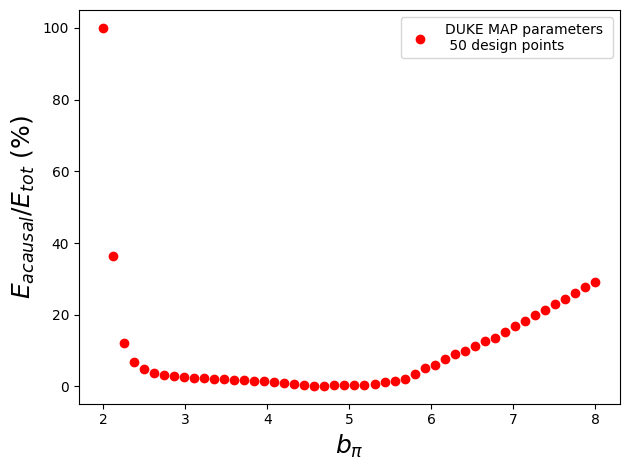

In [ ]:
plt.scatter(model_X.flatten(), 100*model_y.flatten(), color='red', label='DUKE MAP parameters \n 50 design points')
plt.xlabel(r'$b_{\pi}$', fontsize=18)
plt.ylabel('$E_{acausal}/E_{tot}$ (%)', fontsize=18)
#plt.title('Hydro Model Calculations Pb Pb for a central collision')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
print(100*hydro_model(5))

<ipython-input-4-4e5df10dc057>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-4-4e5df10dc057>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-4-4e5df10dc057>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-4-4e5df10dc057>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-4-4e5df10dc057>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-4-4e5df10dc057>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

0.6684034982700527


# **Small Systems**

* **p-Pb (5.04 TeV)**

In [ ]:
# grid config
# Trento options
# leave commented out for min-bias
#b-min = 0 # central
#b-max = 0
x = 7.0  # cross-section in fm^2 (5.04 TeV)
n_ev = 1
seed = 1

# Setting parameters
n = 20 # Normalization factor [GeV] 5.02 TeV
p = 0.0 # Energy deposition parameter
k = 0.19 # nucleon multiplicity fluctuation
n_c = 6 # Number of constituents inside the nucleon.
w = 0.92 # Gaussian nucleon width [fm]
v = 0.43 # Gaussian constituent width in [fm]
d = 0.81 # Minimum inter-nucleon distance [fm]

# generating Trento events
!/root/.local/bin/trento p Pb {n_ev} -p {p} -k {k} -w {w} -d {d} -n {n} -v {v} -m {n_c} --b-min 0 --b-max 0 --random-seed {seed} -q -o Duke_pPb.map

In [ ]:
#Our model for hydrodynamic output

def hydro_model(b_pi):
    """
    This function represents our
    realistic event-by-event hydrodynamic model. Here it is Trento +
    freestreaming model with an additional random noise error.
    """
    shear_factor = b_pi
    profile = np.loadtxt('Duke_pPb.map/0.dat')
    time = 0.37 # Free streaming time [fm/c]
    grid_size = 10

    fs = freestream.FreeStreamer(profile, grid_size, time)
    e = fs.Tuv(0,0)
    bulk = fs.bulk_pressure(eos_spline)
    pi = fs.shear_tensor()

    cs2, p = thermo_QCD(e)

    lambda_1, lambda_2, lambda_3 = pi_eigen(pi)

    C_eta = shear_factor
    C_zeta = C_zeta_func(1/15, cs2)
    Rey = bulk_reynolds(bulk, e, p)

    # necessary conditions
    result_n_1 = n_1(C_eta, Rey, lambda_1, e, p)
    result_n_2 = n_2(C_eta, Rey, lambda_3, e, p)
    result_n_3 = n_3(C_eta, Rey, lambda_3, e, p)
    result_n_4_1_2 = n_4(C_eta, Rey, lambda_1, lambda_2, e, p)
    result_n_4_1_3 = n_4(C_eta, Rey, lambda_1, lambda_3, e, p)
    result_n_4_2_3 = n_4(C_eta, Rey, lambda_2, lambda_3, e, p)
    result_n_4_3_2 = n_4(C_eta, Rey, lambda_3, lambda_2, e, p)
    result_n_4_3_1 = n_4(C_eta, Rey, lambda_3, lambda_1, e, p)
    result_n_4 =  result_n_4_1_2 & result_n_4_1_3 & result_n_4_2_3 & result_n_4_3_2 & result_n_4_3_1
    result_n_5 = n_5(C_eta, C_zeta, cs2, Rey, lambda_1, e, p)
    result_n_6 = n_6(C_eta, C_zeta, cs2, Rey, lambda_3, e, p)

    necessary_conditions = result_n_1 & result_n_2 & result_n_3 & result_n_4 & result_n_5 & result_n_6

    classification = np.where(necessary_conditions, 'purple', 'red')

#    total = classification.size
#    red_mask = (classification == 'red')
#    red_cells = np.count_nonzero(red_mask)
#    red_fraction = red_cells / total

    # Switching / particlization temperature 0.151 [GeV]
    T_switch = 0.151
    e_switch = e_interp(T_switch)

    denominator = e.sum()
    red_mask = (classification == 'red')
    red_numerator = e[red_mask].sum()
    energy_red_fraction = red_numerator / denominator

    y = energy_red_fraction

    return y

hydro_model = np.vectorize(hydro_model)

In [ ]:
n_design_pts = 50 # number of points to run the model
param_min = 2 # minimum value for our parameter
param_max = 8 # maximum value for our parameter

# this chooses our sample to be a regular grid, which is an efficient sampling in one dimension
# it is reshaped into a 2D array so that we can readily use it with scikit-learn
model_X = np.linspace(param_min, param_max, n_design_pts).reshape(-1,1)

#these are causal variables outputs of our hydro model, assuming that the model has finite statistical error
model_y = hydro_model(model_X)

<ipython-input-2-1295f133aa17>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-2-1295f133aa17>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-2-1295f133aa17>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-2-1295f133aa17>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-2-1295f133aa17>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-2-1295f133aa17>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

In [ ]:
print(hydro_model(5))

<ipython-input-2-1295f133aa17>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-2-1295f133aa17>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-2-1295f133aa17>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-2-1295f133aa17>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-2-1295f133aa17>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-2-1295f133aa17>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

0.046986640330979934


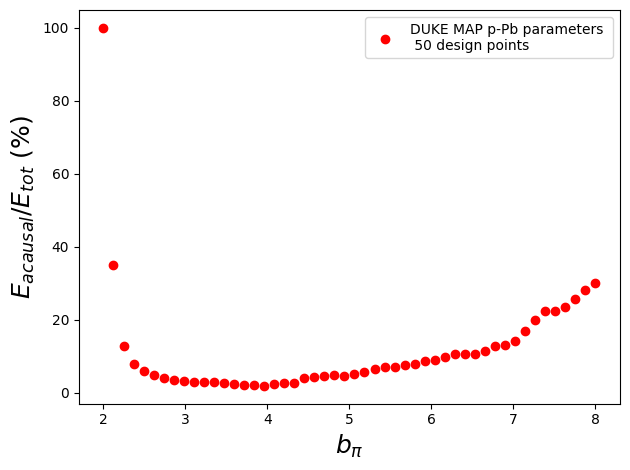

In [ ]:
plt.scatter(model_X.flatten(), 100*model_y.flatten(), color='red', label='DUKE MAP p-Pb parameters \n 50 design points')
plt.xlabel(r'$b_{\pi}$', fontsize=18)
plt.ylabel('$E_{acausal}/E_{tot}$ (%)', fontsize=18)
#plt.title('Hydro Model Calculations Pb Pb for a central collision')
plt.tight_layout()
plt.legend()
plt.show()

Varying free-streaming time

In [ ]:
#Our model for hydrodynamic output

def hydro_model(tau_fs):
    """
    This function represents our
    realistic event-by-event hydrodynamic model. Here it is Trento +
    freestreaming model with an additional random noise error.
    """
    shear_factor = 5
    grid_size = 10
    profile = np.loadtxt('Duke_pPb.map/0.dat')

    fs = freestream.FreeStreamer(profile, grid_size, tau_fs)
    e = fs.Tuv(0,0)
    bulk = fs.bulk_pressure(eos_spline)
    pi = fs.shear_tensor()

    cs2, p = thermo_QCD(e)

    lambda_1, lambda_2, lambda_3 = pi_eigen(pi)

    C_eta = shear_factor
    C_zeta = C_zeta_func(1/15, cs2)
    Rey = bulk_reynolds(bulk, e, p)

    # necessary conditions
    result_n_1 = n_1(C_eta, Rey, lambda_1, e, p)
    result_n_2 = n_2(C_eta, Rey, lambda_3, e, p)
    result_n_3 = n_3(C_eta, Rey, lambda_3, e, p)
    result_n_4_1_2 = n_4(C_eta, Rey, lambda_1, lambda_2, e, p)
    result_n_4_1_3 = n_4(C_eta, Rey, lambda_1, lambda_3, e, p)
    result_n_4_2_3 = n_4(C_eta, Rey, lambda_2, lambda_3, e, p)
    result_n_4_3_2 = n_4(C_eta, Rey, lambda_3, lambda_2, e, p)
    result_n_4_3_1 = n_4(C_eta, Rey, lambda_3, lambda_1, e, p)
    result_n_4 =  result_n_4_1_2 & result_n_4_1_3 & result_n_4_2_3 & result_n_4_3_2 & result_n_4_3_1
    result_n_5 = n_5(C_eta, C_zeta, cs2, Rey, lambda_1, e, p)
    result_n_6 = n_6(C_eta, C_zeta, cs2, Rey, lambda_3, e, p)

    necessary_conditions = result_n_1 & result_n_2 & result_n_3 & result_n_4 & result_n_5 & result_n_6

    classification = np.where(necessary_conditions, 'purple', 'red')

#    total = classification.size
#    red_mask = (classification == 'red')
#    red_cells = np.count_nonzero(red_mask)
#    red_fraction = red_cells / total

    denominator = e.sum()
    red_mask = (classification == 'red')
    red_numerator = e[red_mask].sum()
    energy_red_fraction = red_numerator / denominator

    y = energy_red_fraction

    return y

hydro_model = np.vectorize(hydro_model)

In [ ]:
n_design_pts = 100 # number of points to run the model
param_min = 0.01 # minimum value for our parameter
param_max = 1.5 # maximum value for our parameter

# this chooses our sample to be a regular grid, which is an efficient sampling in one dimension
# it is reshaped into a 2D array so that we can readily use it with scikit-learn
model_X = np.linspace(param_min, param_max, n_design_pts).reshape(-1,1)

#these are causal variables outputs of our hydro model, assuming that the model has finite statistical error
model_y = hydro_model(model_X)

<ipython-input-2-1295f133aa17>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-2-1295f133aa17>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-2-1295f133aa17>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-2-1295f133aa17>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-2-1295f133aa17>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-2-1295f133aa17>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

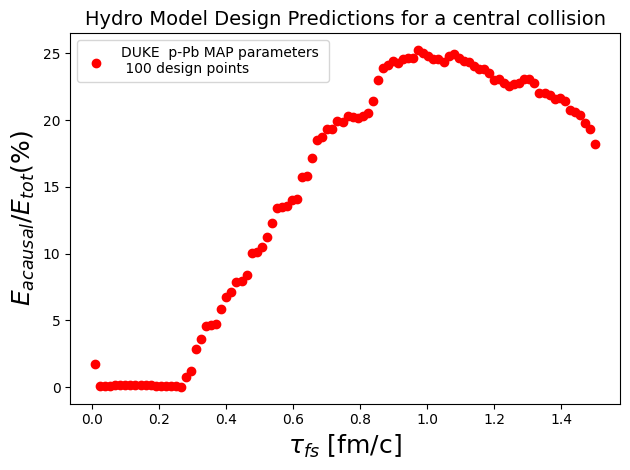

In [ ]:
plt.scatter(model_X.flatten(), 100*model_y.flatten(), color='red', label='DUKE  p-Pb MAP parameters \n 100 design points')
plt.xlabel(r'$\tau_{fs}$ [fm/c]', fontsize=18)
plt.ylabel('$E_{acausal}/E_{tot} (\%)$', fontsize=18)
plt.title('Hydro Model Design Predictions for a central collision', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def hydro_model(alpha):
    """
    This function represents our
    realistic event-by-event hydrodynamic model. Here it is Trento +
    freestreaming model with an additional random noise error.
    """
    shear_factor = 4.65
    grid_size = 10
    profile = np.loadtxt('PbPb.map/0.dat')
    tau_fs = 1.46
    fs = freestream.FreeStreamer(profile, grid_size, tau_fs)
    e = fs.Tuv(0,0)
    bulk = fs.bulk_pressure(eos_spline)
    pi = fs.shear_tensor()

    cs2, p = thermo_QCD(e)

    lambda_1, lambda_2, lambda_3 = pi_eigen(pi)

    C_eta = shear_factor
    b_Pi = 1/14.55
    C_zeta = (b_Pi)/((1/3 - cs2)**alpha)
    Rey = bulk_reynolds(bulk, e, p)

    # necessary conditions
    result_n_1 = n_1(C_eta, Rey, lambda_1, e, p)
    result_n_2 = n_2(C_eta, Rey, lambda_3, e, p)
    result_n_3 = n_3(C_eta, Rey, lambda_3, e, p)
    result_n_4_1_2 = n_4(C_eta, Rey, lambda_1, lambda_2, e, p)
    result_n_4_1_3 = n_4(C_eta, Rey, lambda_1, lambda_3, e, p)
    result_n_4_2_3 = n_4(C_eta, Rey, lambda_2, lambda_3, e, p)
    result_n_4_3_2 = n_4(C_eta, Rey, lambda_3, lambda_2, e, p)
    result_n_4_3_1 = n_4(C_eta, Rey, lambda_3, lambda_1, e, p)
    result_n_4 =  result_n_4_1_2 & result_n_4_1_3 & result_n_4_2_3 & result_n_4_3_2 & result_n_4_3_1
    result_n_5 = n_5(C_eta, C_zeta, cs2, Rey, lambda_1, e, p)
    result_n_6 = n_6(C_eta, C_zeta, cs2, Rey, lambda_3, e, p)

    necessary_conditions = result_n_1 & result_n_2 & result_n_3 & result_n_4 & result_n_5 & result_n_6

    classification = np.where(necessary_conditions, 'purple', 'red')

#    total = classification.size
#    red_mask = (classification == 'red')
#    red_cells = np.count_nonzero(red_mask)
#    red_fraction = red_cells / total

    denominator = e.sum()
    red_mask = (classification == 'red')
    red_numerator = e[red_mask].sum()
    energy_red_fraction = red_numerator / denominator

    y = energy_red_fraction

    return y

hydro_model = np.vectorize(hydro_model)

In [ ]:
n_design_pts = 100 # number of points to run the model
param_min = 2 # minimum value for our parameter
param_max = 3 # maximum value for our parameter

# this chooses our sample to be a regular grid, which is an efficient sampling in one dimension
# it is reshaped into a 2D array so that we can readily use it with scikit-learn
model_X = np.linspace(param_min, param_max, n_design_pts).reshape(-1,1)

#these are causal variables outputs of our hydro model, assuming that the model has finite statistical error
model_y = hydro_model(model_X)

<ipython-input-2-1295f133aa17>:99: RuntimeWarning: divide by zero encountered in divide
  return np.where((energy_density != 0) & (local_pressure != 0), bulk_pressure / (energy_density + local_pressure), 0)
<ipython-input-2-1295f133aa17>:5: RuntimeWarning: invalid value encountered in divide
  condition = 2/C_eta + (6/5)*R_bulk - (5/7)*np.abs(lambda_1)/(e + p)
<ipython-input-2-1295f133aa17>:10: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk - (5/14)*(lambda_3/(e + p))
<ipython-input-2-1295f133aa17>:15: RuntimeWarning: invalid value encountered in divide
  condition = 1/C_eta + (3/5)*R_bulk  - (5/14)*(lambda_3)/(e + p)
<ipython-input-2-1295f133aa17>:20: RuntimeWarning: invalid value encountered in divide
  condition = 1 - 1/C_eta + (2/5)*R_bulk + (9/14)*(lambda_a)/(e + p) - (5/14)*(lambda_d)/(e + p)
<ipython-input-2-1295f133aa17>:25: RuntimeWarning: invalid value encountered in divide
  condition = cs_2 + (4/3)*(1/C_eta) + 1/C_zeta + (22/15 

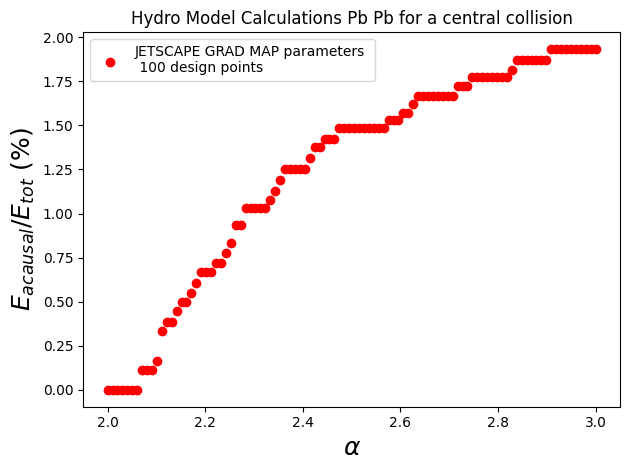

In [ ]:
plt.scatter(model_X.flatten(), 100*model_y.flatten(), color='red', label='JETSCAPE GRAD MAP parameters \n 100 design points')
plt.xlabel(r'$\alpha$', fontsize=18)
plt.ylabel('$E_{acausal}/E_{tot}$ (%)', fontsize=18)
plt.title('Hydro Model Calculations Pb Pb for a central collision')
plt.tight_layout()
plt.legend()
plt.show()